In [1]:
!nvidia-smi

Sun Jan 23 09:12:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Specify path to the data folder from the argminint-21-keypoint-analysis-sahredtask-code repository:

In [3]:
cd /content/drive/MyDrive/argmining-21-keypoint-analysis-sharedtask-code-master/data

/content/drive/MyDrive/argmining-21-keypoint-analysis-sharedtask-code-master/data


In [4]:
pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.4 MB 24.3 MB/s 
     |████████████████████████████████| 6.8 MB 19.3 MB/s 
     |████████████████████████████████| 1.2 MB 58.2 MB/s 
     |████████████████████████████████| 67 kB 7.2 MB/s 
     |████████████████████████████████| 3.3 MB 63.3 MB/s 
     |████████████████████████████████| 895 kB 75.1 MB/s 
     |████████████████████████████████| 596 kB 75.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=b4845dba197896dba76ceedaea7f46865570818a10ccf4d961ab713af2484020
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


In [6]:
pip install transformers

In [7]:
pip install lime

     |████████████████████████████████| 275 kB 4.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=824d985c02e11e2ad9b5023618190bf6d582aa419db8d3aa7996bb6088c9f3c0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [8]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import torch 
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler, losses, models, util
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import TripletEvaluator
import transformers
from datetime import datetime
from zipfile import ZipFile

from sentence_transformers.datasets import SentenceLabelDataset
from sentence_transformers.datasets import NoDuplicatesDataLoader

import csv
import logging
import os
import sys

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

# Evaluation

Specify the model and the models_list with the models you trained

In [9]:
# model = SentenceTransformer('/content/drive/MyDrive/argmining-21-keypoint-analysis-sharedtask-code-master/data/roberta-base-contrastive-10-epochs-2021-12-09_15-30-13')
model = SentenceTransformer('/content/drive/MyDrive/argmining-21-keypoint-analysis-sharedtask-code-master/data/roberta-base-contrastive-3-epochs-32batch-Fine-Tuned-TSDAE64_1_kpm_data-2022-01-05_17-38-13')
models_list = ['/content/drive/MyDrive/argmining-21-keypoint-analysis-sharedtask-code-master/data/roberta-base-contrastive-3-epochs-32batch-Fine-Tuned-TSDAE64_1_kpm_data-2022-01-05_17-38-13']
tokenizer = transformers.RobertaTokenizer.from_pretrained("/content/drive/MyDrive/argmining-21-keypoint-analysis-sharedtask-code-master/data/roberta-base-contrastive-3-epochs-32batch-Fine-Tuned-TSDAE64_1_kpm_data-2022-01-05_17-38-13")
pred_output_path = ''
subset_name= 'our_valid'

Methods are slighlty adjusted for evaluation purpose

In [ ]:
import sys
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score
from matplotlib import pyplot
import numpy as np
import os
import json



def get_ap(df, label_column, top_percentile=0.5):
    top = int(len(df)*top_percentile)
    df = df.sort_values('score', ascending=False).head(top)
    # after selecting top percentile candidates, we set the score for the dummy kp to 1, to prevent it from increasing the precision.
    df.loc[df['key_point_id'] == "dummy_id", 'score'] = 0.99
    return average_precision_score(y_true=df[label_column], y_score=df["score"])

def calc_mean_average_precision(df, label_column):
    precisions = [get_ap(group, label_column) for _, group in df.groupby(["topic", "stance"])]
    return np.mean(precisions)

def evaluate_predictions(merged_df):
    mAP_strict = calc_mean_average_precision(merged_df, "label_strict")
    mAP_relaxed = calc_mean_average_precision(merged_df, "label_relaxed")
    print(f"mAP strict= {mAP_strict} ; mAP relaxed = {mAP_relaxed}")

def load_kpm_data(gold_data_dir, subset):
    arguments_file = os.path.join(gold_data_dir, f"arguments_{subset}.csv")
    key_points_file = os.path.join(gold_data_dir, f"key_points_{subset}.csv")
    labels_file = os.path.join(gold_data_dir, f"labels_{subset}.csv")

    arguments_df = pd.read_csv(arguments_file)
    key_points_df = pd.read_csv(key_points_file)
    labels_file_df = pd.read_csv(labels_file)

    return arguments_df, key_points_df, labels_file_df


def get_predictions(predictions_file, labels_df, arg_df):
    arg_df = arg_df[["arg_id", "topic", "stance"]]
    predictions_df = load_predictions(predictions_file)
    #make sure each arg_id has a prediction
    predictions_df = pd.merge(arg_df, predictions_df, how="left", on="arg_id")

    #handle arguements with no matching key point
    predictions_df["key_point_id"] = predictions_df["key_point_id"].fillna("dummy_id")
    predictions_df["score"] = predictions_df["score"].fillna(0)

    #merge each argument with the gold labels
    merged_df = pd.merge(predictions_df, labels_df, how="left", on=["arg_id", "key_point_id"])

    merged_df.loc[merged_df['key_point_id'] == "dummy_id", 'label'] = 0
    merged_df["label_strict"] = merged_df["label"].fillna(0)
    merged_df["label_relaxed"] = merged_df["label"].fillna(1)
    return merged_df


"""
this method chooses the best key point for each argument
and generates a dataframe with the matches and scores
"""
def load_predictions(predictions_dir):
    arg =[]
    kp = []
    scores = []
    with open(predictions_dir, "r") as f_in:
        res = json.load(f_in)
        for arg_id, kps in res.items():
            best_kp = max(kps.items(), key=lambda x: x[1])
            arg.append(arg_id)
            kp.append(best_kp[0])
            scores.append(best_kp[1])
        print(f"loaded predictions for {len(arg)} arguments")
        return pd.DataFrame({"arg_id" : arg, "key_point_id": kp, "score": scores})

def match_argument_with_keypoints(result, kp_dict, arg_dict):
    
    for arg, arg_embedding in arg_dict.items():
        result[arg] = {}
        for kp, kp_embedding in kp_dict.items():
            # print(type(util.pytorch_cos_sim(arg_embedding, kp_embedding).item()))
            # print(type(float(np.linalg.norm(arg_embedding - kp_embedding))))
            result[arg][kp] = util.pytorch_cos_sim(arg_embedding, kp_embedding).item()
            # result[arg][kp] = float(1-np.linalg.norm(arg_embedding - kp_embedding))
        
        #Applying softmax
        kp_scores = list(result[arg].items())
        kp_ids, kp_scores = zip(*kp_scores)
        #print(kp_ids)
        #print(kp_scores)
        #kp_scores = torch.softmax(torch.Tensor(kp_scores), 0).tolist()
        #print(kp_scores)
        result[arg] = {kp_id:score for kp_id, score in zip(kp_ids, kp_scores)}
        

    return result

def predict(model, argument_df, keypoint_df, output_path, append_topic=False):
    argument_keypoints = {}
    for topic in argument_df.topic.unique():
        for stance in [-1, 1]:
            topic_keypoints_ids = keypoint_df[(keypoint_df.topic==topic) & (keypoint_df.stance==stance)]['key_point_id'].tolist()
            topic_keypoints = keypoint_df[(keypoint_df.topic==topic) & (keypoint_df.stance==stance)]['key_point'].tolist()
            if append_topic:
                topic_keypoints = [topic + ' <SEP> ' + x for x in topic_keypoints]
                
            topic_keypoints_embeddings = model.encode(topic_keypoints)
            topic_kp_embed = dict(zip(topic_keypoints_ids, topic_keypoints_embeddings))

            topic_arguments_ids = argument_df[(argument_df.topic==topic) & (argument_df.stance==stance)]['arg_id'].tolist()
            topic_arguments = argument_df[(argument_df.topic==topic) & (argument_df.stance==stance)]['argument'].tolist()
            topic_arguments_embeddings = model.encode(topic_arguments)
            topic_arg_embed= dict(zip(topic_arguments_ids, topic_arguments_embeddings))

            argument_keypoints = match_argument_with_keypoints(argument_keypoints, topic_kp_embed, topic_arg_embed)
    print(argument_keypoints)
    print(type(argument_keypoints))
    json.dump(argument_keypoints, open(output_path, 'w'))
    return argument_keypoints

def predict_and_evaluate(argument_df, keypoint_df, gold_data_dir, subset_name):
    pred_df = {}
    for model_path in models_list:
        append_topic= 'topic_added' in model_path
        #Predict
        model = SentenceTransformer(model_path)
        model_name = model_path.split('/')[-1]
        predictions_file = pred_output_path+model_name+ '-' + subset_name + '-preds.json'
        json_preds = predict(model, argument_df, keypoint_df, predictions_file, append_topic)
        

        #Evaluate
        arg_df, kp_df, labels_df = load_kpm_data(gold_data_dir, subset=subset_name)
        merged_df = get_predictions(predictions_file, labels_df, arg_df)
        print('Evaluating {}:'.format(model_name))
        evaluate_predictions(merged_df)
        
        pred_df[model_name] = merged_df

    return pred_df

Load test data

specify the path to the original dataframe

In [ ]:
test_arg_df = pd.read_csv('../KPA_2021_shared_task/test_data/arguments_test.csv')
test_keypoints_df = pd.read_csv('../KPA_2021_shared_task/test_data/key_points_test.csv')
labels_test = pd.read_csv("../KPA_2021_shared_task/test_data/labels_test.csv")

In [ ]:
results_df = predict_and_evaluate(test_arg_df, test_keypoints_df, '../KPA_2021_shared_task/test_data/', 'test')

{'arg_0_0': {'kp_0_0': 0.8606645464897156, 'kp_0_1': 0.5099940896034241, 'kp_0_2': 0.37604305148124695, 'kp_0_3': 0.8411097526550293}, 'arg_0_1': {'kp_0_0': 0.8974505662918091, 'kp_0_1': 0.5319494009017944, 'kp_0_2': 0.43570181727409363, 'kp_0_3': 0.8936020731925964}, 'arg_0_2': {'kp_0_0': 0.8732459545135498, 'kp_0_1': 0.49745431542396545, 'kp_0_2': 0.3987497091293335, 'kp_0_3': 0.8689494132995605}, 'arg_0_3': {'kp_0_0': 0.7575106620788574, 'kp_0_1': 0.4864659905433655, 'kp_0_2': 0.4093873202800751, 'kp_0_3': 0.7350186109542847}, 'arg_0_4': {'kp_0_0': 0.8506049513816833, 'kp_0_1': 0.611437976360321, 'kp_0_2': 0.49134302139282227, 'kp_0_3': 0.8768203258514404}, 'arg_0_5': {'kp_0_0': 0.5495750904083252, 'kp_0_1': 0.7964096069335938, 'kp_0_2': 0.8123070597648621, 'kp_0_3': 0.5810853242874146}, 'arg_0_6': {'kp_0_0': 0.9110808968544006, 'kp_0_1': 0.5070445537567139, 'kp_0_2': 0.3903768062591553, 'kp_0_3': 0.8957526683807373}, 'arg_0_7': {'kp_0_0': 0.9468475580215454, 'kp_0_1': 0.51892489194

# Leave One Out

In [ ]:
import transformers
import shap
import plotly.graph_objects as go

In [ ]:
def leaveOneOutPrediction(model, arg_id, kp_id, arg_df, kp_df):
    arg = arg_df.loc[arg_df["arg_id"] == arg_id, "argument"].values[0]
    kp = kp_df.loc[kp_df["key_point_id"] == kp_id, "key_point"].values[0]
    print("Argument: ", arg)
    print("Key point: ", kp)
    leftout_arg = createRemovalDic(arg)
    # print(leftout_arg)
    res = computeMarginalImpact(model, arg, kp, leftout_arg)
    return res

In [ ]:
def createRemovalDic(arg):
    arg_list = arg.split()
    leftoutlist = {}
    for i in range(len(arg_list)):
      out = arg_list.copy()
      key = out[i]
      del out[i]
      sentence = " ".join(out)
      leftoutlist[key] = sentence
    return leftoutlist

def computeMarginalImpact(model, arg, kp, leftout_arg):
    arg_embed = model.encode(arg)
    kp_embed = model.encode(kp)
    ref = util.pytorch_cos_sim(arg_embed, kp_embed).item()
    result = {}
    print(ref)
    for key, value in leftout_arg.items():
      value_embed = model.encode(value)
      result[key] = ref - util.pytorch_cos_sim(value_embed, kp_embed).item()
    return result

class marginals():

    def __init__(self, shaps, data):
        self.values = shaps
        self.shape = shaps.shape
        self.base_values = 0.0
        self.data = data
        self.output_names = None

def visualizeMarginalImpactWords(model, arg, kp, arg_df, kp_df):
    leaveOneOut = leaveOneOutPrediction(model, arg, kp, arg_df, kp_df)
    margin = np.array(list(leaveOneOut.values()))
    words = np.array(list(leaveOneOut.keys()))
    # print(margin)
    margin = marginals(margin, words)
    shap.plots.text(margin)

def visualizeMarginalImpactWordsBarPlot(model, arg, kp, arg_df, kp_df):
    leaveOneOut = leaveOneOutPrediction(model, arg, kp, arg_df, kp_df)
    df = pd.DataFrame({
        "word": list(leaveOneOut.keys()),
        "contribution": list(leaveOneOut.values()) 
    })
    
    df["Color"] = np.where(df["contribution"]<0.0, 'blue', 'red')

    fig = go.Figure()
    fig.add_trace(
        go.Bar(name='contribution',
              x=df['word'],
              y=df['contribution'],
              marker_color=df['Color']))
    fig.update_layout(barmode='stack')
    fig.show()
 


In [ ]:
labels_test

arg_id key_point_id  label
0     arg_0_112       kp_0_4      0
1     arg_0_112       kp_0_5      0
2     arg_0_112       kp_0_6      0
3     arg_0_112       kp_0_7      1
4       arg_0_0       kp_0_0      0
...         ...          ...    ...
3421  arg_1_232       kp_1_9      0
3422  arg_0_111       kp_0_3      0
3423  arg_0_111       kp_0_0      1
3424  arg_0_111       kp_0_1      0
3425  arg_0_111       kp_0_2      0

[3426 rows x 3 columns]

# Visualization of Leave One Out Perturbations
Parameters: 
  - Model
  - Argument ID
  - Keypoint ID
  - Argument Dataframe
  - Keypoint Dataframe


---
Return: 
Model Visualizes the marginal impact of each word in the argument to the similarity score between argument and keypoint

In [ ]:
visualizeMarginalImpactWords(model, "arg_0_7", "kp_0_0", test_arg_df, test_keypoints_df)

Argument:  Child vaccination should not be mandatory as there are often side effects from them
Key point:  Routine child vaccinations, or their side effects, are dangerous
0.9468473196029663


In [ ]:
visualizeMarginalImpactWords(model, "arg_0_76", "kp_0_0", test_arg_df, test_keypoints_df)

Argument:  child vaccinations is not mandatory because it may cost the country unnecessary funds.
Key point:  Routine child vaccinations, or their side effects, are dangerous
0.5147095918655396


In [ ]:
visualizeMarginalImpactWords(model, "arg_0_0", "kp_0_0", test_arg_df, test_keypoints_df)

Argument:  Routine child vaccinations isn't mandatory since children don't spread the virus
Key point:  Routine child vaccinations, or their side effects, are dangerous
0.8606643676757812


In [ ]:
visualizeMarginalImpactWordsBarPlot(model, "arg_0_0", "kp_0_0", test_arg_df, test_keypoints_df)

Argument:  Routine child vaccinations isn't mandatory since children don't spread the virus
Key point:  Routine child vaccinations, or their side effects, are dangerous
0.8606643676757812


# LIME 
The LIME Algorithms has been adjusted to work for siamese neural networks. In order to train a classifier that can approximate the similarity score locally the keypoint is fixed and the local neighbourhood of the Argument is used to explain which parts of the argument influence the prediction score the most. 

The Lime Package is used and modified in two files (lime_base.py and explanation.py) to account for the siamese architecture instead of a classifier.

lime_base.py

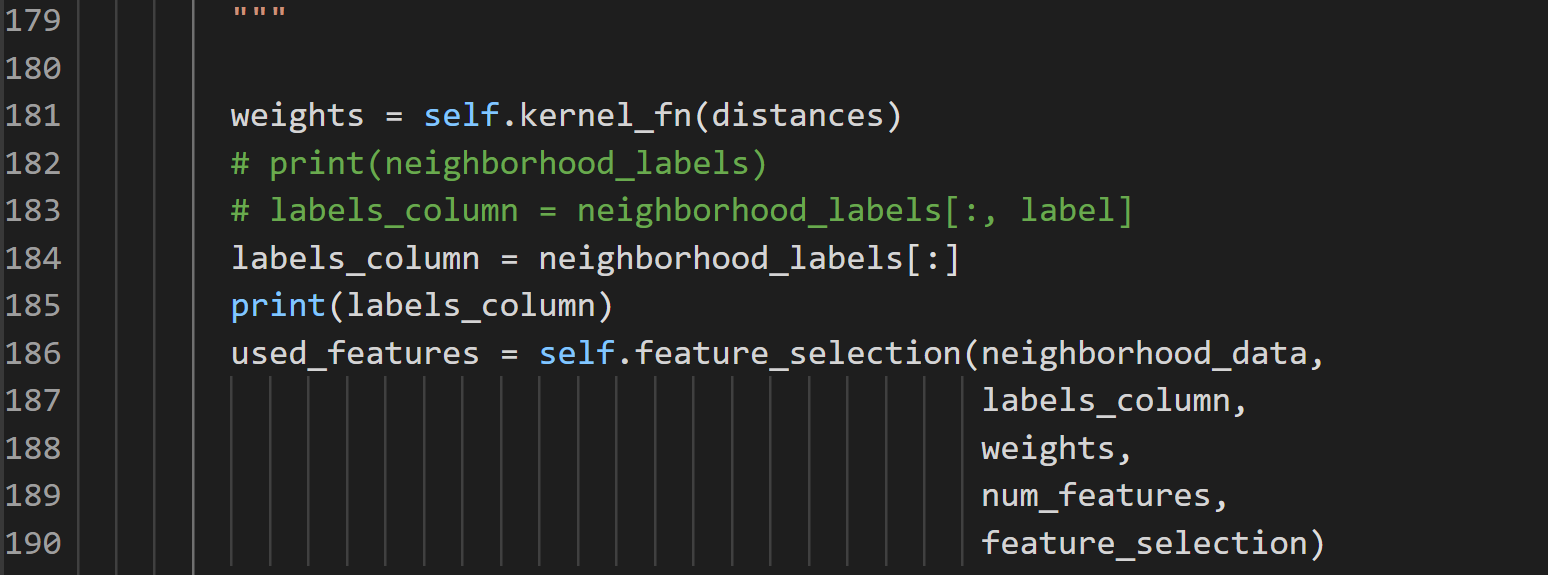

explanation.py

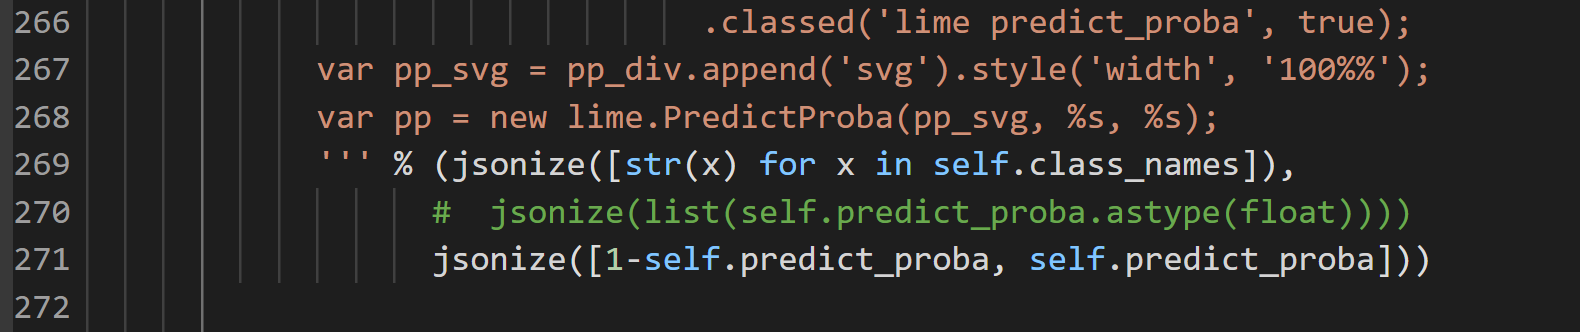

The LIME function visualized the parts of the argument that contribute most to the predicted similarity between the argument and the keypoint.


---

Parameter: 


*   model: siamese neural network
*   arg: argument id of the argument that should be explained
*   kp: key point id of the keypoint that is kept fix 
*   arg_df: dataframe containing the arguments
*   kp_df: dataframe containing the key points
*   removeWords: List of words that should be removed from the argument - Use it for validychecks (Does prediction score decrease?)










In [ ]:
def predlime(x, model, kp):
    # print(x)
    # kp = test_keypoints_df.loc[test_keypoints_df["key_point_id"] == "kp_0_2", "key_point"].values[0]
    kp_embed = model.encode(kp)
    res = []
    for el in x: 
      arg_embed = model.encode(el) 
      # print(util.pytorch_cos_sim(arg_embed, kp_embed).item())
      r = util.pytorch_cos_sim(arg_embed, kp_embed).item()
      res.append(r)
      
    return res

In [ ]:
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

def lime(model, arg, kp, arg_df, kp_df, labels_df, removeWord=None):
    class_names = {0: 'dissimilar', 1:'similar'}
    LIME_explainer = LimeTextExplainer(class_names=class_names)
    label = labels_df.loc[(labels_df["arg_id"] == arg) & (labels_df["key_point_id"] == kp), "label"].values[0]
    topic = arg_df.loc[arg_df["arg_id"] == arg, "topic"].values[0]
    argument = arg_df.loc[arg_df["arg_id"] == arg, "argument"].values[0]
    if removeWord is not None:
        for el in removeWord: 
            argument = argument.replace(el, "")  
    keypoint = kp_df.loc[kp_df["key_point_id"] == kp, "key_point"].values[0]
    LIME_exp = LIME_explainer.explain_instance(argument, classifier_fn=lambda x: predlime(x, model, keypoint))
    print("Topic: ", topic)
    print('Argument: ', argument)
    print('Key Point: ', keypoint)
    print('Similarity =', predlime([argument], model, keypoint)[0], "True Label: ", label)
    print("0 = dissimilar, 1 = similar")
    print('R2 score: {:.3f}'.format(LIME_exp.score))
    # show the explainability results 
    LIME_exp.show_in_notebook(text=True)

In [ ]:
lime(model, "arg_0_1", "kp_0_0", test_arg_df, test_keypoints_df, labels_test)

Topic:  Routine child vaccinations should be mandatory
Argument:  Routine child vaccinations should not be mandatory because children may not bear the side effects of it.
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Similarity = 0.8974505066871643 True Label:  1
0 = dissimilar, 1 = similar
R2 score: 0.836


In [ ]:
lime(model, "arg_0_1", "kp_0_0", test_arg_df, test_keypoints_df, ["effects", "vaccinations"])

Topic:  Routine child vaccinations should be mandatory
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Similarity = 0.6453005075454712
1 = similar, 0 = dissimilar
R2 score: 0.739
None


# Negotiation Handling!
lime(model, "arg_0_10", "kp_0_0", test_arg_df, test_keypoints_df)
lime(model, "arg_0_1", "kp_0_0", test_arg_df, test_keypoints_df)

# Great Example
lime(model, "arg_0_100", "kp_0_0", test_arg_df, test_keypoints_df)
lime(model, "arg_0_100", "kp_0_2", test_arg_df, test_keypoints_df)
 

---
Fist one is dissimilar whereas second one is similar: Specially the different
impact of the word decision is interesting!

In [ ]:
lime(model, "arg_2_156", "kp_2_11", test_arg_df, test_keypoints_df, labels_test)

Topic:  The USA is a good country to live in
Argument:  The United States is undoubtedly the richest country that exists, its income is really high and higher than that of any other country, apart from being one of the main productive countries on the planet.
Key Point:  The US has a good economy/high standard of living
Similarity = 0.7798954844474792 True Label:  1
0 = dissimilar, 1 = similar
R2 score: 0.752


# SHAP

The Shap function computes the shap values for a given keypoint and all arguments of the same topic.


---

Parameter: 


*   model: siamese neural network
*   arg: List of argument ids that should be explained - For single instance explanations provide a list of length 1 containing the respective argument
*   kp: String of key point id of the keypoint that is kept fix 
*   arg_df: dataframe containing the arguments
*   kp_df: dataframe containing the key points
*   removeWords: List of words that should be removed from the argument - Use it for validychecks










In [ ]:
import shap
import transformers
import torch
import numpy as np
import scipy as sp

def getSamples(arg, kp, arg_df, kp_df, labels_df):
    merged=labels_df.merge(arg_df, left_on="arg_id", right_on="arg_id")
    full_dataset=merged.merge(kp_df, left_on="key_point_id", right_on="key_point_id")
    
    key_point = full_dataset.loc[full_dataset["key_point_id"] == kp, "key_point"].values[0]
    topic = full_dataset.loc[full_dataset["key_point_id"] == kp, "topic_x"].values[0]
    arguments = full_dataset.loc[(full_dataset["arg_id"].isin(arg)) & (full_dataset["key_point_id"] == kp)]
    # Get all Arguments within a certain topic
    # arguments = full_dataset.loc[(full_dataset["topic_x"] == topic) & (full_dataset["key_point_id"] == kp)]

    return arguments

def getSingleSamples(kp, arg, arg_df, kp_df, labels_df):
    merged=labels_df.merge(arg_df, left_on="arg_id", right_on="arg_id")
    full_dataset=merged.merge(kp_df, left_on="key_point_id", right_on="key_point_id")
    
    key_point = full_dataset.loc[full_dataset["key_point_id"] == kp, "key_point"].values[0]
    topic = full_dataset.loc[full_dataset["key_point_id"] == kp, "topic_x"].values[0]
    arguments = full_dataset.loc[(full_dataset["arg_id"] == arg) & (full_dataset["key_point_id"] == kp)]

    return arguments


def cleanShapValues(shapleys):
    shaps = shapleys.data
    new_shaps = []
    for sh in shaps: 
      new_sh =[]
      for s in sh:    
        new_s = s.replace("Ġ", "")
        new_sh.append(new_s)
      new_shaps.append(np.array(new_sh))
    new_shapleys = tuple(new_shaps)
    shapleys.data = new_shapleys

    new_feature_names = []
    feature_name_list = shapleys.feature_names
    for features in feature_name_list: 
        feature_list = []
        for feat in features:
            new_feat = feat.replace("Ġ", "")
            feature_list.append(new_feat)
        new_feature_names.append(feature_list)
    shapleys.feature_names = new_feature_names
    return shapleys

def predictshap(x, model, kp):
    result = []
    for el in x:
      arg_embed = model.encode(el)
      kp_embed = model.encode(kp)
      r = util.pytorch_cos_sim(arg_embed, kp_embed).item()
      result.append(r)
    return result

def plotheader(model, arg, kp, arg_df, kp_df, labels_df):
    merged=labels_df.merge(arg_df, left_on="arg_id", right_on="arg_id")
    full_dataset=merged.merge(kp_df, left_on="key_point_id", right_on="key_point_id")
    if len(arg) == 1: 
        arg = arg[0]
      
        argument = full_dataset.loc[(full_dataset["arg_id"] == arg) & (full_dataset["key_point_id"] == kp), "argument"].values[0]
        keypoint = full_dataset.loc[(full_dataset["arg_id"] == arg) & (full_dataset["key_point_id"] == kp), "key_point"].values[0]
        topic = full_dataset.loc[full_dataset["key_point_id"] == kp, "topic_x"].values[0]
        label = full_dataset.loc[(full_dataset["arg_id"] == arg) & (full_dataset["key_point_id"] == kp), "label"].values[0]

        print("Topic: ", topic)
        print('Argument: ', argument)
        print('Key Point: ', keypoint)
        print('Similarity =', predictshap([argument], model, keypoint)[0], "True Label: ", label)
        print("0 = dissimilar, 1 = similar")
    
    else: 
        keypoint = full_dataset.loc[full_dataset["key_point_id"] == kp, "key_point"].values[0]
        topic = full_dataset.loc[full_dataset["key_point_id"] == kp, "topic_x"].values[0]
        print("Topic: ", topic)
        print('Key Point: ', keypoint)
        for a in arg:
           argument = full_dataset.loc[(full_dataset["arg_id"] == a) & (full_dataset["key_point_id"] == kp), "argument"].values[0]
           label = full_dataset.loc[(full_dataset["arg_id"] == a) & (full_dataset["key_point_id"] == kp), "label"].values[0]
           print("Argument: ", argument, "Similarity: ", predictshap([argument], model, keypoint)[0], "True Label: ", label)



In [ ]:
#  Calculation of shapley values
def shaps(model, tokenizer, arg, kp, arg_df, kp_df, labels_df):
    shap_train = getSamples(arg, kp, test_arg_df, test_keypoints_df, labels_df)
    # if num_sentences == 1:
    #     print("SINGLE")
    #     shap_train = getSingleSamples(kp, arg, test_arg_df, test_keypoints_df, labels_df)
    # print(shap_train)
    keypoint = kp_df.loc[kp_df["key_point_id"] == kp]["key_point"]
    train = shap_train[:]["argument"]

    explainer = shap.Explainer(lambda x: predictshap(x, model, keypoint), tokenizer)
    shap_values = explainer(train, fixed_context=1)
    # shap_values_clean = deepcopy(shap_values)
    shap_values_clean = cleanShapValues(shap_values)
    return shap_values_clean


In [ ]:
#  specify the argument and the keypoint you would like to analyze
ARG = ["arg_0_3"]
KP = "kp_0_0"

In [ ]:
shap_values = shaps(model, tokenizer, ARG, KP, test_arg_df, test_keypoints_df, labels_test)

# Local Analysis

*   num_sentences == 1: has to be one since it is a single instance plot

In [ ]:
shap_values = shaps(model, tokenizer, ARG, KP, test_arg_df, test_keypoints_df, labels_test)

Text Plot




---


When we pass a single instance to the text plot we get the importance of each token overlayed on the original text that corresponds to that token. Red regions correspond to parts of the text that increase the output of the model when they are included, while blue regions decrease the output of the model when they are included. In the context of the sentiment analysis model here red corresponds to a more positive review and blue a more negative review.







In [ ]:
plotheader(model, ARG, KP, test_arg_df, test_keypoints_df, labels_test)
shap.plots.text(shap_values[0])

Topic:  Routine child vaccinations should be mandatory
Argument:  Routine child vaccinations should not be mandatory because children may not bear the side effects of it.
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Similarity = 0.8974505066871643 True Label:  1
0 = dissimilar, 1 = similar


Local Bar Plot

---
Passing a row of SHAP values to the bar plot function creates a local feature importance plot, where the bars are the SHAP values for each feature.


Topic:  Routine child vaccinations should be mandatory
Argument:  A vaccine that has not been sufficiently tested and without knowledge of side effects is not recommended for children
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Similarity = 0.7575106024742126 True Label:  1
0 = dissimilar, 1 = similar


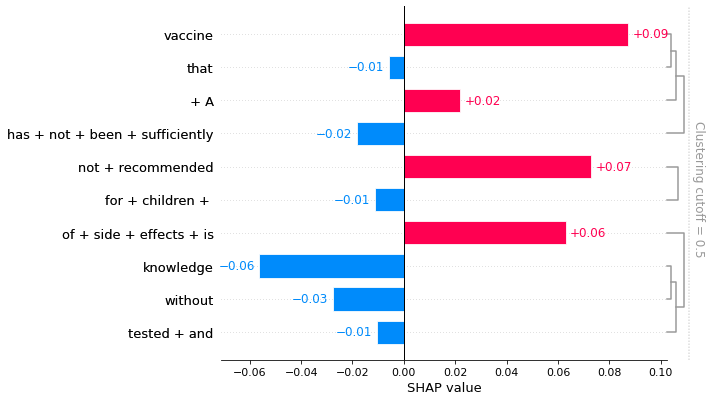

In [ ]:
plotheader(model, ARG, KP, test_arg_df, test_keypoints_df, labels_test)
shap.plots.bar(shap_values[0])

Waterfall Plot: 


---


Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.



Bugs: In order to use Waterfall plot for text, replace in _waterfall.py line 126 with `yticklabels[rng[i]] = feature_names[order[i]]`

Topic:  Routine child vaccinations should be mandatory
Argument:  A vaccine that has not been sufficiently tested and without knowledge of side effects is not recommended for children
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Similarity = 0.7575106024742126 True Label:  1
0 = dissimilar, 1 = similar


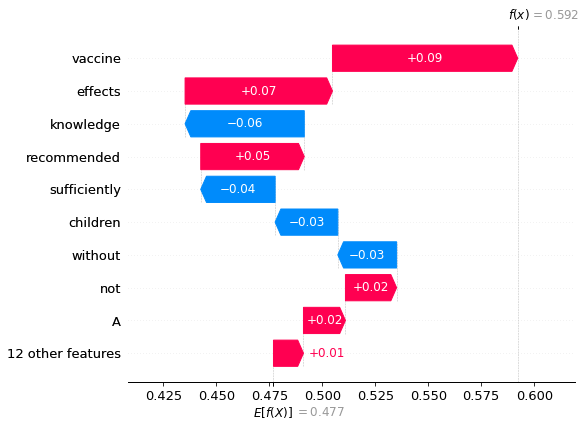

In [ ]:
shap_values = shaps(model, tokenizer, ARG, KP, test_arg_df, test_keypoints_df, labels_test)
plotheader(model, ARG, KP, test_arg_df, test_keypoints_df, labels_test)
shap.plots.waterfall(shap_values[0])

#Global Analysis




*   len(arg) >= 2: The Argument List has to contain more than one word since it is a multi-instance **plot**



In [ ]:
MULTIARG = ["arg_0_0", "arg_0_1", "arg_0_2"]
shap_values = shaps(model, tokenizer, MULTIARG, KP, test_arg_df, test_keypoints_df, labels_test)

Multi Instance Text Plot


---

When we pass a multi-row explanation object to the text plot we get the single instance plots for each input instance scaled so they have consistent comparable x-axis and color ranges.

In [ ]:
plotheader(model, MULTIARG, KP, test_arg_df, test_keypoints_df, labels_test)
shap.plots.text(shap_values[:])

Topic:  Routine child vaccinations should be mandatory
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Argument:  Routine child vaccinations isn't mandatory since children don't spread the virus Similarity:  0.8606643676757812 True Label:  0
Argument:  Routine child vaccinations should not be mandatory because children may not bear the side effects of it. Similarity:  0.8974505066871643 True Label:  1
Argument:  Routine child vaccinations should not be necessary as children can't catch the disease Similarity:  0.8732458353042603 True Label:  0


/usr/local/lib/python3.7/dist-packages/slicer/slicer_internal.py:443: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Global Bar Plot


---

Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples. It analyzes the words in a list of arguments and shows which words are the most important in order to increase the similarity to a given Keyword.


Topic:  Routine child vaccinations should be mandatory
Key Point:  Routine child vaccinations, or their side effects, are dangerous
Argument:  Routine child vaccinations isn't mandatory since children don't spread the virus Similarity:  0.8606643676757812 True Label:  0
Argument:  Routine child vaccinations should not be mandatory because children may not bear the side effects of it. Similarity:  0.8974505066871643 True Label:  1
Argument:  Routine child vaccinations should not be necessary as children can't catch the disease Similarity:  0.8732458353042603 True Label:  0


/usr/local/lib/python3.7/dist-packages/slicer/slicer_internal.py:443: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/shap/_explanation.py:532: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



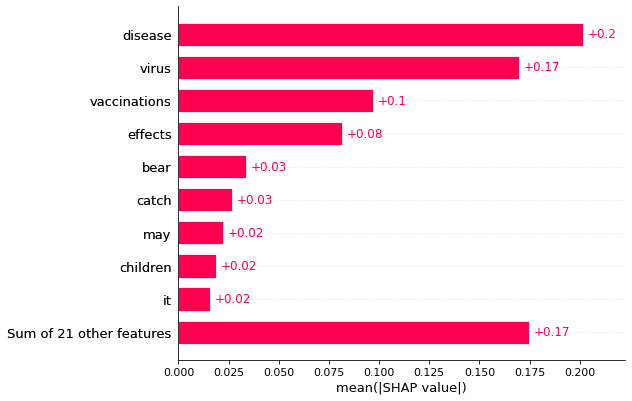

In [ ]:
plotheader(model, MULTIARG, KP, test_arg_df, test_keypoints_df, labels_test)
shap.plots.bar(shap_values[:])